# Data Exploratory

In this workbook, we aim to find recurring pattern that would be a good indicator on whether user will reorder particular items.

### Import libraries, read off data into panda dataframes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
aisles = pd.read_csv('./data/aisles.csv')
dept = pd.read_csv('./data/departments.csv')
orders = pd.read_csv('./data/orders.csv')
products = pd.read_csv('./data/products.csv')

In [3]:
orders_p = pd.read_csv('./data/order_products__prior.csv')
orders_tr = pd.read_csv('./data/order_products__train.csv')

In [4]:
prior_order = orders.query('eval_set == "prior"')
train_order = orders.query('eval_set == "train"')
test_order = orders.query('eval_set == "test"')

In [5]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
order_p_detail = pd.merge(orders_p, prior_order, on='order_id', how='left')

In [8]:
order_tr_detail = pd.merge(orders_tr, train_order, on='order_id', how='left')

In [9]:
product_full_detail = pd.merge(products, dept, on='department_id').merge(
    aisles, on='aisle_id')

##### Merge information across dataframe to form one consolidated dataframe.

In [10]:
consol_detail = pd.merge(order_p_detail, product_full_detail, on='product_id')

In [11]:
# Final results with all product details consolidated into one table
consol_detail.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,dairy eggs,eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,dairy eggs,eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,dairy eggs,eggs


### Exploring Product Category

In [12]:
product_order = consol_detail.groupby(
    ['department', 'reordered'])['order_id'].nunique().unstack(level=1)

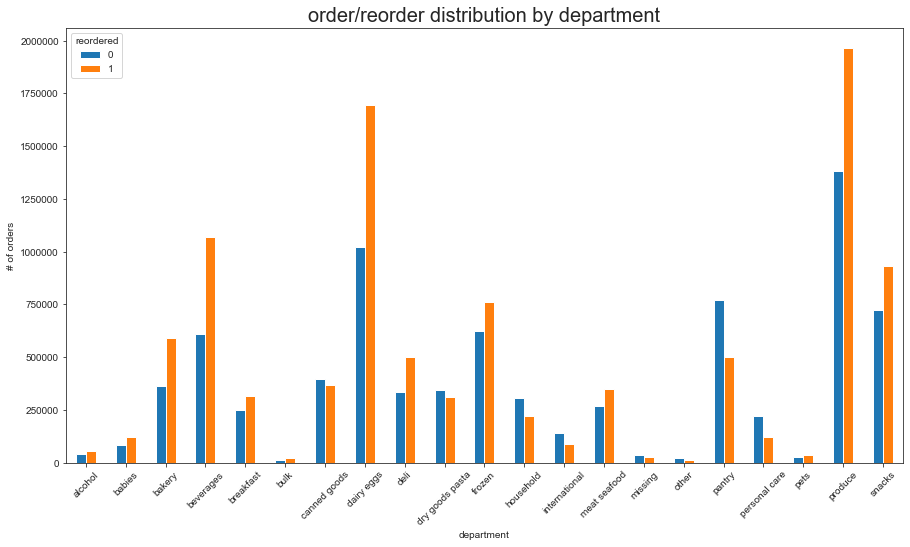

In [13]:
product_order.plot(kind='bar', figsize=(15, 8))
plt.xticks(rotation=45)
plt.ylabel('# of orders')
plt.title('order/reorder distribution by department', fontsize=20)
plt.show()

##### At the department level, beverages, dairy and produce appear to have the highest re-purchasing rates. Pantry does not seem to be popular items on re-purchasing.

We will dive into these three categories to see if there are different re-purchasing patterns at the aisle level.

In [14]:
aisle_order = consol_detail.groupby(
    ['department', 'aisle','reordered'])['order_id'].nunique().unstack(level=2)

In [15]:

def plotting_func(dataset, string):
    """Steps to create bar graph

    Args:
    dataset: groupby dataframe to be passed to graph
    string: aisle category to be plotted

    Returns:
    matplotlib graph object
    """
    dataset.loc[string].plot(kind='bar', figsize=(8, 4))
    plt.xticks(rotation=45)
    plt.ylabel('# of orders')
    plt.title('# of orders by {}'.format(string), fontsize=15)
    plt.tight_layout()
    plt.show()

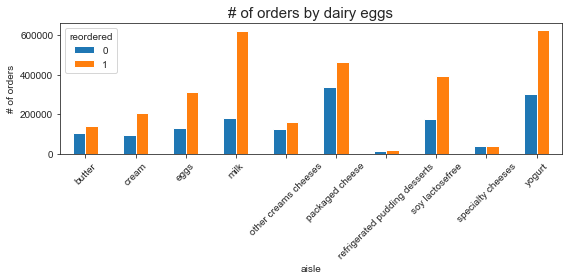

In [16]:
plotting_func(aisle_order, 'dairy eggs')

Re-purchasing pattern is consistent across all aisle except cheeses, milk and yogurt is the most popular aisles

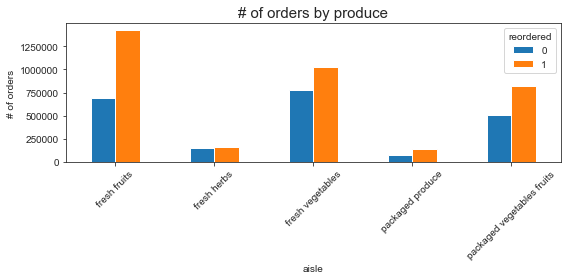

In [17]:
plotting_func(aisle_order, 'produce')

Fruits appears to have stronger re-purchasing pattern.

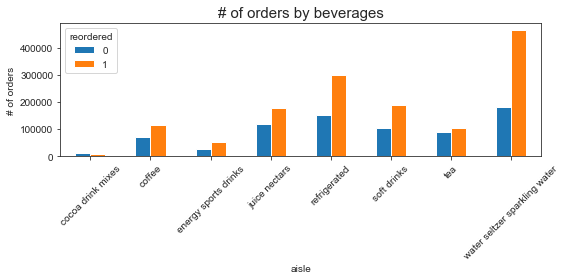

In [18]:
plotting_func(aisle_order, 'beverages')

Water is predominately the category that drives re-purchasing

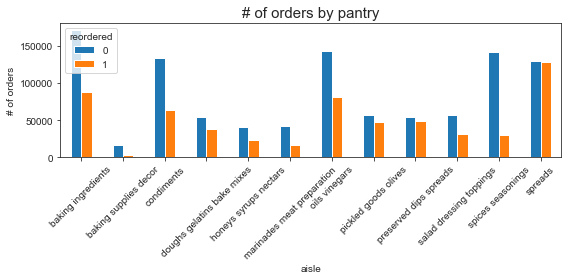

In [19]:
plotting_func(aisle_order, 'pantry')

All aisles within pantry do not have strong re-purchasing pattern

**Observation**: The more generic the product is (i.e. water, milk, fruits), the higher the rate for re-purchasing

### Exploring the product mix change over time

Given the likelihood on repeating purchase varies across aisle. Let see if there is a consistent pattern on order item mix over time. From what what obeserved above, we would expect diary eggs, produces, and beverages will occupied bigger proportion of the baskets as the number of re-orders increase.

In [20]:
dept_order = pd.crosstab(consol_detail['order_number'],
                         consol_detail['department'], normalize='index')

In [21]:
dept_order_lg = dept_order[dept_order > .05].dropna(axis=1, how='all')
dept_order_sm = dept_order[(dept_order < .05) &
                           (dept_order > .01)].dropna(axis=1, how='all')

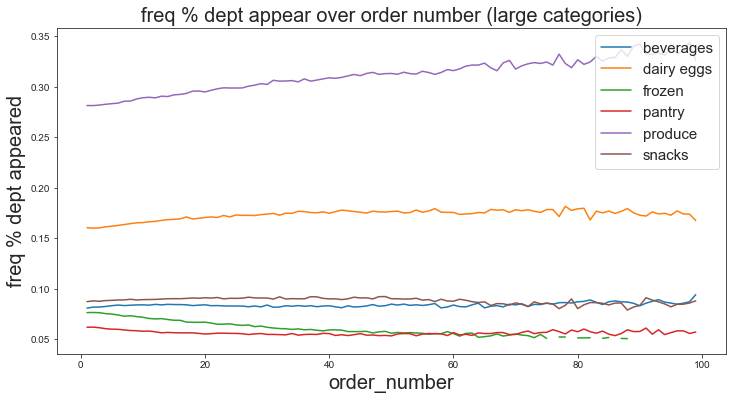

In [22]:
dept_order_lg.plot.line(figsize=(12, 6))
plt.legend(loc='best', fontsize=15)
plt.xlabel('order_number', fontsize=20)
plt.ylabel('freq % dept appeared', fontsize=20)
plt.title('freq % dept appear over order number (large categories)',
          fontsize=20)
plt.show()

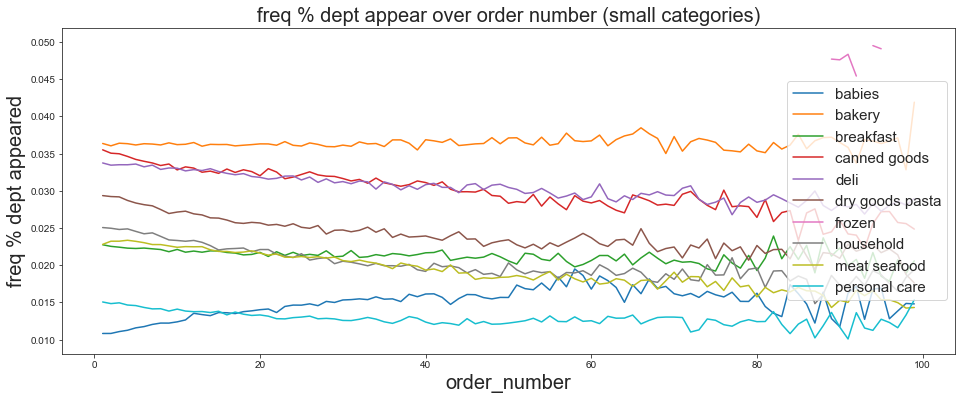

In [23]:
dept_order_sm.plot.line(figsize=(16, 6))
plt.legend(loc='right', fontsize=15)
plt.xlabel('order_number', fontsize=20)
plt.ylabel('freq % dept appeared', fontsize=20)
plt.title('freq % dept appear over order number (small categories)',
          fontsize=20)
plt.show()

**Observation**: Consistence to assumed belief, produce is the popular category for re-ordering. Beverages, dairy eggs, and snacks also have consistent in appearance. This implies that for particular users, the big item category purchased in each order could be pretty consistent overtime. Small item categories, in general, appear less often on re-ordering, except babies products.

### Exploring item per order trend

We are interested to see if there are consistence pattern on the number of product being adding to carts. Would number of items change as users re-order more often. We will use add_to_cart_order max value to make that equal to number of items purchases

In [24]:
# At overall order level
order_id_order = consol_detail.groupby(['order_id'])['add_to_cart_order'].max()
print('Average items per order are {:.2f}'.format(np.mean(order_id_order)))

Average items per order are 10.09


In [25]:
order_id_num = consol_detail.groupby(['order_id', 'order_number',
                                      'order_dow'])['add_to_cart_order'].max()
order_id_num = order_id_num.reset_index()

In [26]:
order_num_item = order_id_num.groupby(['order_number', 'order_dow'])['add_to_cart_order'].mean()

In [27]:
order_num_item = order_num_item.reset_index()
order_num_item

,order_number,order_dow,add_to_cart_order
0,1,0,11.046862
1,1,1,10.203814
2,1,2,9.566024
3,1,3,9.361875
4,1,4,9.390858
...,...,...,...
688,99,2,9.060302
689,99,3,8.386139
690,99,4,8.623810
691,99,5,9.875622


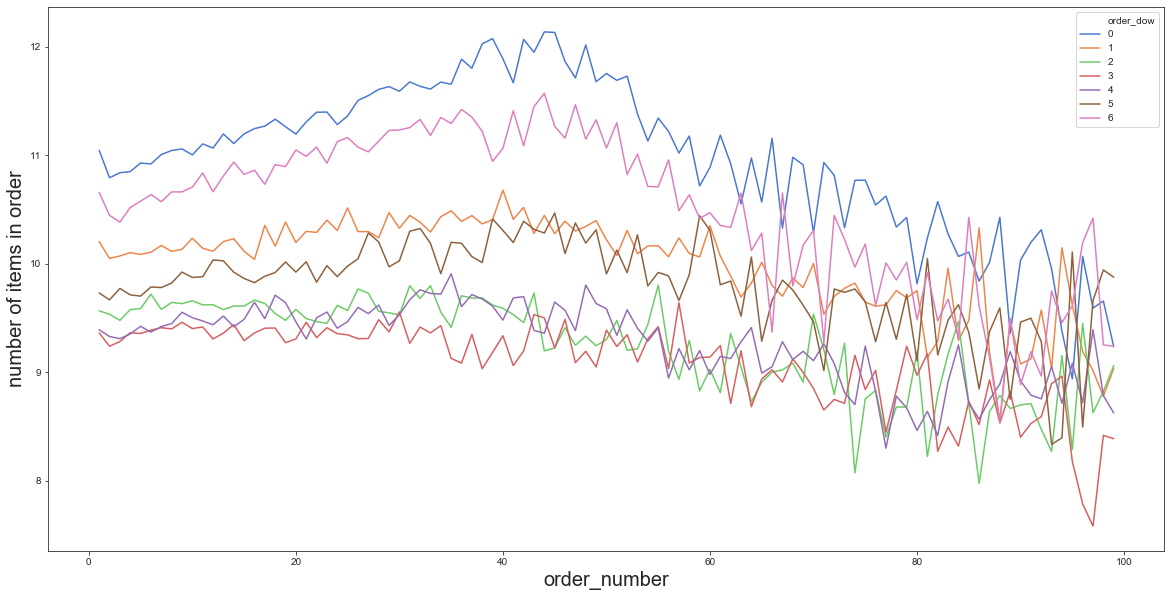

In [28]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='order_number', y='add_to_cart_order', hue='order_dow',
             data=order_num_item, legend='full', palette='muted')
plt.legend(loc='best')
plt.xlabel('order_number', fontsize=20)
plt.ylabel('number of items in order', fontsize=20)
plt.show()

**Observation**: On average, around 9-10 item are added to cart, The number of items per order is relatively stable. Orders placed on day of week 0 and 6 have higher item count on average.

### Exploring Day and Hour of ordering

In [29]:
dow_hour_orders = consol_detail.groupby(['order_dow',
                                         'order_hour_of_day'])['order_id'].nunique()
dow_hour_orders = dow_hour_orders.reset_index()

In [30]:
dow_hour_pivot = dow_hour_orders.pivot(columns='order_dow',
                                       index='order_hour_of_day', values='order_id')

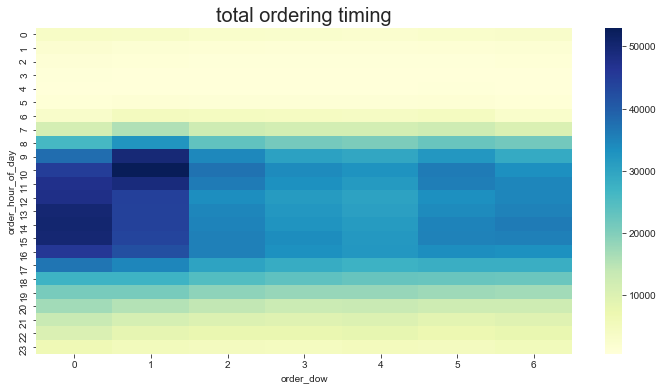

In [31]:
plt.figure(figsize=(12, 6))
sns.heatmap(dow_hour_pivot, cmap="YlGnBu")
plt.title('total ordering timing', fontsize=20)
plt.show()

Day 0 and 1 have the most orders being placed. Generally, most orders are placed between 8am to 6pm. 

We will check if it applies to re-ordering orders

In [32]:
dow_hour_reorders = consol_detail.query('reordered == 1').groupby(['order_dow', 'order_hour_of_day'])['order_id'].nunique().reset_index()

In [33]:
dow_hour_reorder_pivot = dow_hour_reorders.pivot(columns='order_dow',index='order_hour_of_day', values='order_id')

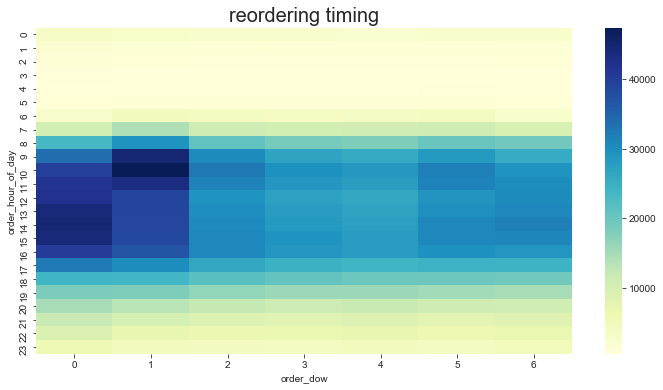

In [34]:
plt.figure(figsize=(12, 6))
sns.heatmap(dow_hour_reorder_pivot, cmap="YlGnBu")
plt.title('reordering timing', fontsize=20)
plt.show()

Re-ordering pattern is consistent with total ordering pattern.

### Exploring if order timing varies by products

In [35]:
dow_product = consol_detail.groupby(['order_dow', 'department_id'])['order_id'].nunique().reset_index()

In [36]:
dow_product_ct = pd.crosstab(dow_product['order_dow'], dow_product['department_id'], values=dow_product['order_id'], aggfunc=sum,normalize='columns')

In [37]:
# dow_product_ct.T.style.format('{:.0%}')

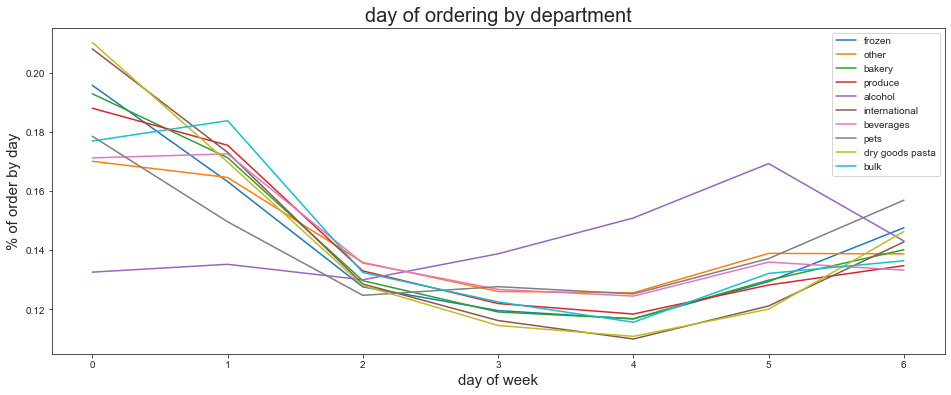

In [38]:
plt.figure(figsize=(16, 6))
for i in range(1,11):
    sns.lineplot(x=dow_product_ct.index, y=dow_product_ct[i], label=dept.loc[i-1]['department'])
plt.title('day of ordering by department', fontsize=20)
plt.ylabel('% of order by day', fontsize=15)
plt.xlabel('day of week', fontsize=15)
plt.legend(loc='best')
plt.show()

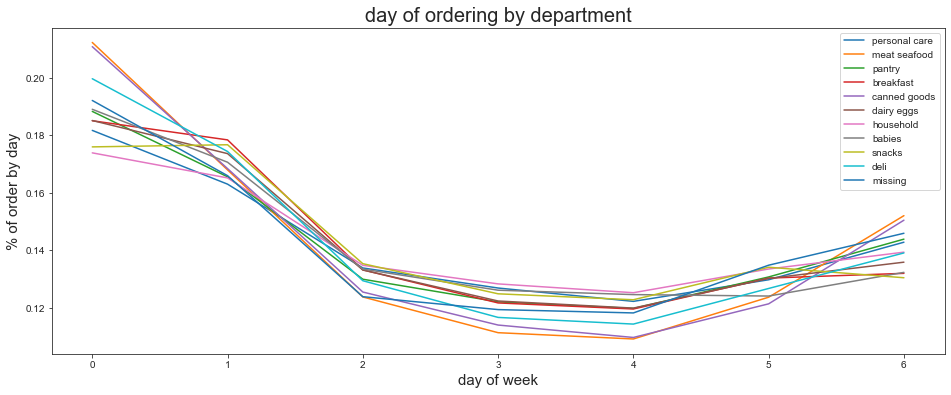

In [39]:
plt.figure(figsize=(16, 6))
for i in range(11,22):
    sns.lineplot(x=dow_product_ct.index, y=dow_product_ct[i], label=dept.loc[i-1]['department'])
plt.title('day of ordering by department', fontsize=20)
plt.ylabel('% of order by day', fontsize=15)
plt.xlabel('day of week', fontsize=15)
plt.legend(loc='best')
plt.show()

**Observation**: Product ordering pattern varies throughout the week (e.g. alcohol).

### Exploring day lags on reordering and order frequency

We want to see how often user will purchase from Instacart in terms of days, how many purchases will a user make with Instacart, access users attrition rates. 

**Disclaimer**: Users who had joined longer will naturally have more purchase history while newer users will only have 1-2 purchases. Since dataset did not state the date that a particular user was joined and when the purchases were made, we are developing observations by ***ignoring the time factor*** on length of membership and date of purchase. We assume that current dataset is a good representative of user purchase habits.

In [40]:
prior_train = pd.concat([prior_order, train_order])

In [41]:
prior_train = prior_train.sort_values(by=['user_id', 'order_number'],
                                      ascending=[1, 1])

In [42]:
prior_train.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [43]:
prior_train_select = prior_train[['order_number', 'days_since_prior_order']]

In [44]:
order_lag = prior_train_select.groupby('order_number').agg({
    'days_since_prior_order': 'mean'}).reset_index()

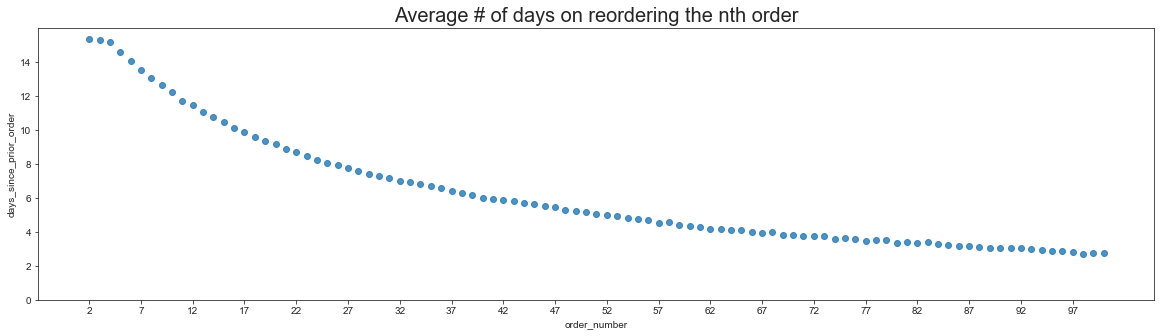

In [45]:
plt.figure(figsize=(20, 5))
sns.regplot(x='order_number', y='days_since_prior_order', data=order_lag,fit_reg=False)
plt.xticks(np.arange(2, 100, 5))
plt.yticks(np.arange(0, 16, 2))
plt.title('Average # of days on reordering the nth order', fontsize=20)
plt.show()

**Observation**: For the first 3 orders, the day separation is about 15 days, and gradually decrease as the user re-order more often.

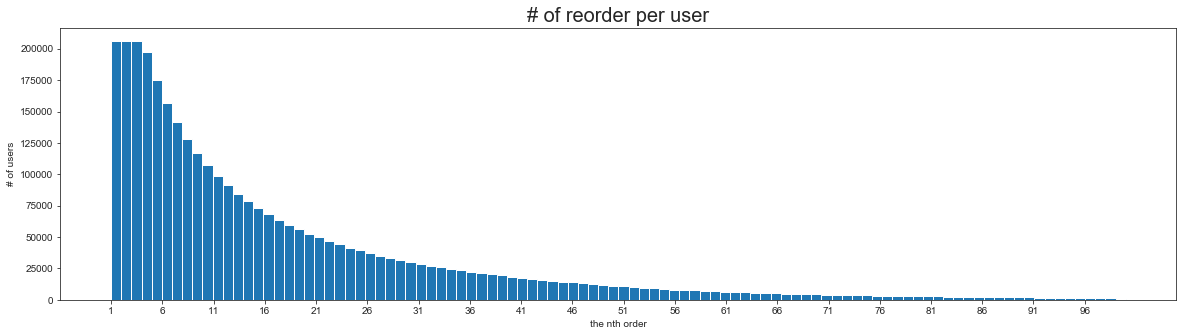

In [46]:
plt.figure(figsize=(20, 5))
plt.hist(prior_train_select['order_number'], bins=100)
plt.xticks(np.arange(1, 100, 5))
plt.xlabel('the nth order')
plt.ylabel('# of users')
plt.title('# of reorder per user', fontsize=20)
plt.show()

**Observations**: Majority of the users will use the service for 3-4 times, and observe user attrition for starting the 5th purchases.

To convert that into percentage:

In [47]:
table = pd.DataFrame(prior_train_select['order_number'].value_counts())

In [48]:
table['%_penetration'] = table['order_number']/206209

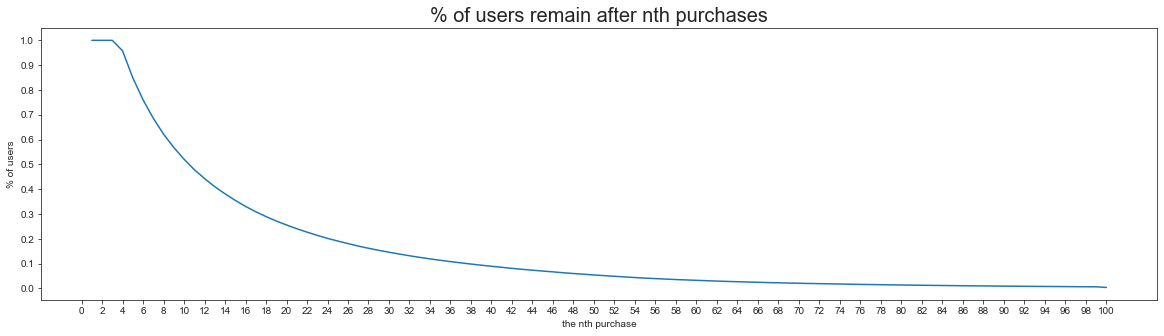

In [49]:
plt.figure(figsize=(20, 5))
plt.plot(table['%_penetration'])
plt.xticks(np.arange(0, 101, 2))
plt.yticks(np.arange(0, 1.1, .1))
plt.xlabel('the nth purchase')
plt.ylabel('% of users')
plt.title('% of users remain after nth purchases', fontsize=20)
plt.show()

**Observation**: After the 4th purchase, users attrition rates is at ~5% per additional one re-purchase. By th 10th purchase, only 50% of users remain using the services. About 10% of the users making 38th purchase or more. Referring to the lag day chart, those purchase on average is 6 days difference, we could assume that those are loyal customers as they purchase something from Instacart every week.

### Summary of Learning
- Product categories has different re-order rate, among all beverage (water), diary eggs (milk, yogurt) and produce (fruits) are most popular items for re-ordering. Pantry items are the least likely to be re-ordered
- Product categories mix does not vary significantly over time. Users will gradually trade off one item favor the other, but the re-order items appear to be similar to the previous order that user made 
- Users tend to purchase on day 0 and 1, from 9am to 4pm
- Some products are being purchased on different days
- Most users who signed up will use the service for 3-4 times, on average 15 days between each other, then users attrition starts. Perhaps that's opportunity to improve user loyalty. 10% of the users become very loyal to the service and purchase among every week.
- In each order, around 9-10 items are added to carts.